Parameter Fitting
===

Having trained the density ratios in the `Neural_Likelihood_Ratio_Estimation.ipynb` and `Systematic_Uncertainty_Estimation.ipynb` notebooks, we are ready for the final parameter fitting step of the workflow.

We defined Signal Region (SR) and Control Region (CR) channels in the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, using a preselection NN that isolates signal-rich phase space for the NSBI fitting, with a background-rich phase space used for detailed validations as well as constraining background parameters.

In [65]:
import os, sys, importlib
# sys.path.append('../')

import nsbi_common_utils
from nsbi_common_utils import plotting, training, inference
import glob
import numpy as np

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import pickle
import matplotlib.pyplot as plt
import yaml

from nsbi_common_utils.inference import nsbi_inference

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

hep.style.use(hep.style.ATLAS)


In [66]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [67]:
# path prefix for general save directory
path_prefix = config['path_prefix']

# sub-path for saving cached data used between modules
path_saved_data = config['path_saved_data']
saved_data = f'{path_prefix}{path_saved_data}'


# Get the dictionary of labels to processes
labels_dict = config["labels_dict"]

# Signal processes in the model
signal_processeses = config["signal_processes"]

# Background processes in the model
background_processes = config["background_processes"]

mix_model_hypotheses = config["mix_model_hypotheses"]
ref_processes = config["ref_processes"]

all_process = signal_processeses + background_processes

channels_binned = config["channels_binned"]
channels_unbinned = config["channels_unbinned"]

print(channels_binned)
print(channels_unbinned)

['SR_binned', 'CR']
['SR']


In [68]:
# Load the nominal dataset for evaluation
dataset = pd.read_hdf(f"{saved_data}dataset_preselected_nominal_SR.h5", key="dataset", mode='r')

mask_processes = {}
for process_type in all_process:
    mask_processes[process_type] = dataset.type==process_type

# Mask that extracts the expected Asimov dataset
process_asimov = all_process

mask_Asimov = np.logical_or.reduce([mask_processes[process_type] for process_type in process_asimov])
weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())

/tmp/ipykernel_179/3818765506.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())


In [69]:
path_to_dict_systs = f"{saved_data}dict_systs.npy"

# Check if user has provided uncertainty NPs
if "dict_systs" in config:
    dict_systs = config["dict_systs"]
    # Load the SR yield variations
    with open(f"{saved_data}yield_SR_variations.pkl", "rb") as fp:
        nu_var_SR = pickle.load(fp)
    # Save the Control Region variation histogram
    with open(f"{saved_data}hist_binned_variations.pkl", "rb") as fp:
        hist_variations = pickle.load(fp)
else:
    dict_systs = {}


# Total number of unconstrained parameters in the model
num_unconstrained_params = config["num_unconstrained_params"]

# List of unconstrained parameter labels
list_unconstrained_params = config["list_unconstrained_params"]

# Full list of systematics
list_syst = [key for key in dict_systs]

print(list_syst)

[]


In [70]:
# Define the full list of parameters to be used in the model
list_params_all = list_unconstrained_params + list_syst


# Asimov values
params_Asimov = jnp.array(np.append(np.array([1.0, 1.0, 1.0]), 
                                    np.zeros(len(list_syst)) ) )


In [71]:
# Get the expected yields corresponding to the various channels
hist_channels = {}
hist_channels['SR'] = {}

for process_type in all_process:
    
    hist_channels['SR'][process_type]        = dataset[mask_processes[process_type]].weights.sum()


In [72]:
hist_channels_data = {}
hist_channels_data['SR'] = np.sum([hist_channels['SR'][process_type] for process_type in process_asimov], axis=0)

In [73]:
hist_channel_variations = None

In [74]:
# Get the saved density ratios

# Save paths
# top_path = f'{path_prefix}output_training_nominal/'
top_path = f'{path_prefix}{path_saved_data}output_training_nominal/'


ratios = {}
ratios['SR'] = {}

for process_type in mix_model_hypotheses:

    path_to_ratio = f'{top_path}output_ratios_{process_type}/ratio_{process_type}.npy'
    ratios['SR'][process_type] = jnp.array(np.load(path_to_ratio)[mask_Asimov])

for process in all_process:
    if process not in mix_model_hypotheses:

        ratios['SR'][process] = jnp.array(np.ones_like(ratios['SR'][mix_model_hypotheses[0]]))


In [75]:

for channel in channels_binned:
    with open(f"{saved_data}hist_binned_{channel}.pkl", "rb") as fp:
            hist_channels[channel] = pickle.load(fp)

    hist_channels_data[channel] = np.sum([hist_channels[channel][process_type] for process_type in process_asimov], axis=0)

print(hist_channels)


{'SR': {'htautau': 844.6183, 'ttbar': 5317.6255, 'ztautau': 339302.88}, 'SR_binned': {'htautau': array([4.7001405], dtype=float32), 'ztautau': array([33.668922], dtype=float32), 'ttbar': array([1.3680663], dtype=float32)}, 'CR': {'htautau': array([3.4308802e-02, 1.9245273e+00, 1.4397985e+01, 1.4372072e+02],
      dtype=float32), 'ztautau': array([2.6406991e+00, 2.5416725e+02, 1.9917854e+04, 6.4259150e+05],
      dtype=float32), 'ttbar': array([  110.26796,  8016.983  , 20536.422  ,  9058.744  ], dtype=float32)}}


In [76]:
ratio_variations = None
hist_channel_variations = None
ratios_var_1sigma = None


Having processed all the inputs needed, we build the likelihood model in the `nsbi_inference` class of `common_utils/inference.py`:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Getting some metadata from the config file to build the model:

In [77]:
process_index = config["process_index"]

floating_processes    = config["floating_processes"]
fixed_processes       = config["fixed_processes"]

print(floating_processes)
print(fixed_processes)

['htautau', 'ttbar', 'ztautau']
[]


In [78]:
importlib.reload(sys.modules['nsbi_common_utils.inference'])
from nsbi_common_utils.inference import nsbi_inference

# Initialize the inference class / module
inference_full = nsbi_inference(channels_binned, channels_unbinned, params_Asimov, 
                                num_unconstrained_params, all_process, fixed_processes, floating_processes, 
                                process_index, ratios, ratio_variations, weights_Asimov, hist_channels_data, hist_channels, 
                                hist_channel_variations, list_params_all)

Profiled negative log-likelihood scans
===

The fitting step involves `iminuit` to minimize the log-likelihood ratio model and build the profile negative log-likelihood test statistic:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x_i|\hat{\mu}, \hat{\alpha})/p_{ref}(x)} + \sum_m^{N_\text{systs}} \alpha_m^2$$

In [79]:
# Perform fit while floating all the NPs
inference_full.perform_fit(fit_strategy=2, freeze_params=[])

fit: 
 ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.576e+07                 │         Nfcn = 68, Ngrad = 1         │
│ EDM = 5.07e-06 (Goal: 0.0002)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────

So the best-fit value from the toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_{t\bar{t}} \neq \mu^\text{truth}_{t\bar{t}} = 1.0$.

Unlike a binned Poisson likelihood fit, which by definition converges to the truth value for Asimov and has well-defined asymptotic statistical properties - this is not guaranteed in an NSBI analysis.

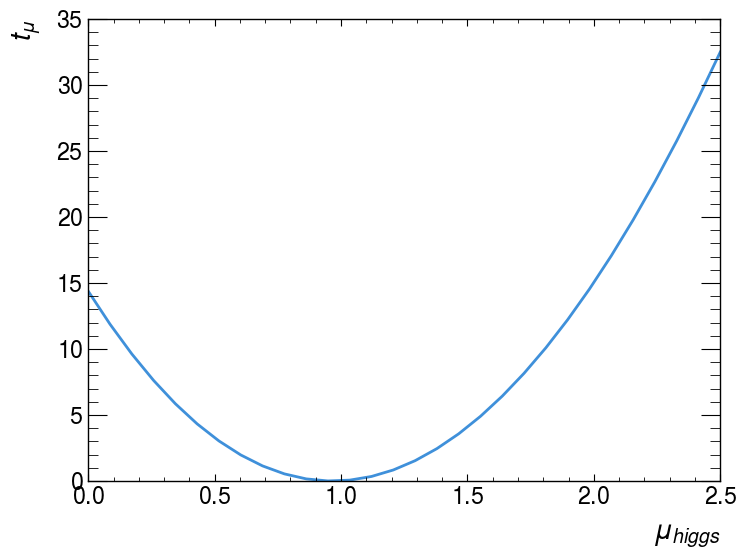

In [80]:
inference_full.plot_NLL_scan(parameter_name='mu_higgs', 
                             parameter_label = r'$\mu_{higgs}$', 
                             bound_range=(0.0, 2.5), fit_strategy=2)

Note again that the best-fit values of even the background normalization parameters in this toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\alpha} \neq \alpha^\text{truth} = 0.0$.

Optimizing the analysis
===

**As we increase the number of parameters, the robustness of the density ratio modelling becomes more important. Building ensembles and optimizing preselections are important. Each of the $O(100)$ nuisance paramters typical in an LHC analysis needs to be checked for bias.**

Things that can be optimized for better convergence:

- Generate more simulated events for better modelling.
- Tighter preselections - removing more of the background-rich phase space $p_{ref}\sim 0$ that can cause numerical instabilites, removing phase space regions with low Monte Carlo statistics or that are difficult to model, etc.
- Add more input features for easier signal-background separation.
- Changing the hyperparameters of the various NNs used in the modelling.
- Training ensembles of NNs


# Need for JIT

While the time and function call seem negligible in this fit with only 3 parameters, JIT compilation becomes **essential** in a fit with $O(100)$ parameters typical in an LHC fit. **Without the compiled functions, the fit can go on for weeks!**

Additional modules to be added
===


- **Neyman Construction**

  Neyman construction requires sampling pseudo-experiments from the Asimov dataset and fitting parameters for each of the pseudo-experiment. The detailed method for performing this in an unbinned NSBI analysis is given in the ATLAS paper (https://arxiv.org/pdf/2412.01600).

  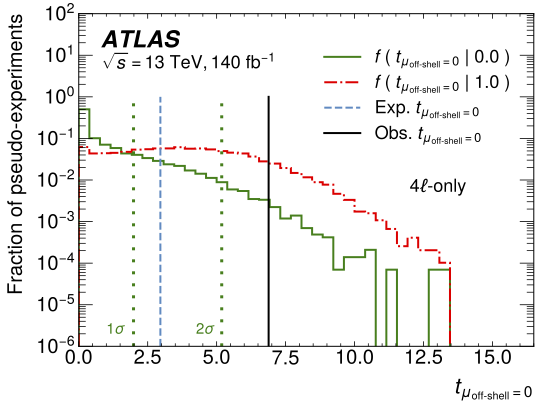

  The fitting of parameters for each of the hundreds of thousands of pseudo-experiments in a typical Neyman Construction, however, is computationally expensive and needs optimized workflows that were built for the ATLAS analysis and will be included in the tutorial soon.

- **Monte Carlo Statistical Uncertainties**

  To account for the uncertainties due to the limited Monte Carlo statistics used in the training data, a novel technique inspired by the spurious signals method and model ensembling was developed for the ATLAS publication. The detailed method for performing this in an unbinned NSBI analysis is given in the ATLAS papers and the corresponding modules will be added soon (requires ensemble training).


More Diagnostics
===

- **Signal injection tests**

  By fitting parameters with truth Asimov data generated at various values of the model parameters, ensure closure of the best fit values within Monte Carlo statistical uncertainties.
  
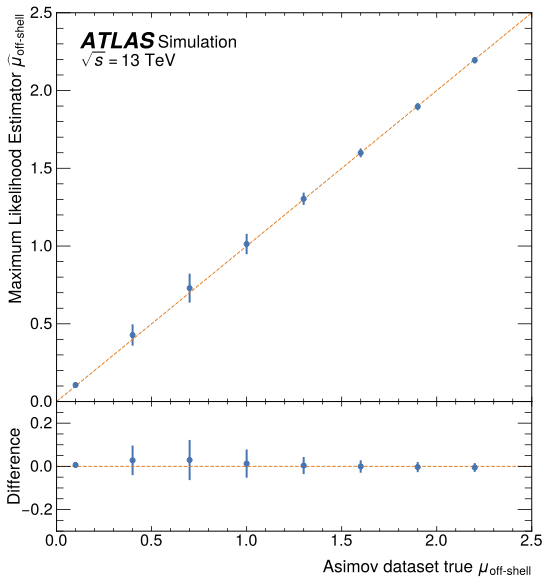

- **Data-MC validations**

  Detailed data-MC validations are perfromed both pre- and post-unblinding to verify the NNs as well as identify phase space regions associated with any data-MC differences.
  
  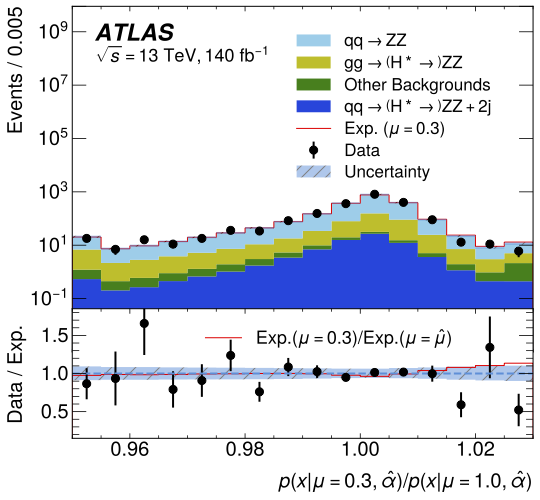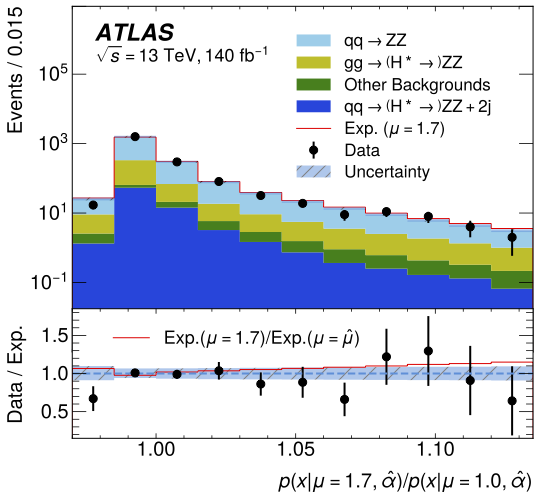